In [1]:
%pip install sunpy astropy sherpa matplotlib -q

from pathlib import Path
import zipfile, gzip
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time

# import sherpa

# import sunpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
data_file = "AL1_SLX_L1_20250303_v1.0.zip"

with zipfile.ZipFile('data/' + data_file, 'r') as z:

    internal_path = f"{data_file.split('.zip')[0]}/SDD2/AL1_SOLEXS_{data_file.split('_')[3]}_SDD2_L1.lc.gz"
    
    with z.open(internal_path) as compressed_file:  # Open the .gz file inside the zip
        
        with gzip.GzipFile(fileobj=compressed_file) as decompressed_file:  # Decompress it
            
            hdul = fits.open(decompressed_file)  # Now open with fits
            hdul.info()  # Show headers and extensions
            display(hdul[0].header)
            display(hdul[1].header)
            hdr0 = hdul[0].header
            hdr1 = hdul[1].header

Filename: AL1_SLX_L1_20250303_v1.0/SDD2/AL1_SOLEXS_20250303_SDD2_L1.lc.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     39   86400R x 2C   [D, D]   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MISSION = 'ADITYA-L1'          / Name of mission/satellite                      
TELESCOP= 'AL1     '           / Name of mission/satellite                      
INSTRUME= 'SoLEXS  '           / Name of Instrument/detector                    
ORIGIN  = 'SoLEXSPOC'          / Source of FITS file                            
CREATOR = 'solexs_pipeline-1.2' / Creator of file                               
FILENAME= 'AL1_SOLEXS_20250303_SDD2_L1.lc' / Name of file                       
CONTENT = 'LIGHT CURVE'        / File content                                   
DATE    = '2025-04-08'         / Creation Date                                  
OBS_DATE= '20250303'        

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                86400 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
EXTNAME = 'RATE    '           / Extension name                                 
CONTENT = 'LIGHT CURVE'        / File content                                   
HDUCLASS= 'OGIP    '           / format conforms to OGIP standard               
HDUVERS = '1.1.0   '           / Version of format (OGIP memo CAL/GEN/92-002a)  
HDUDOC  = 'OGIP memos CAL/GE

In [3]:
data_dir = Path('data')            # folder of 24-hour zip files
tables = []                        # collect each day’s table here

for zip_path in sorted(data_dir.glob('*.zip')):
    day = zip_path.stem.split('_')[3]
    prefix = f"{zip_path.stem}/SDD2/"

    with zipfile.ZipFile(zip_path, 'r') as z:
        for member in z.namelist():
            if member.startswith(prefix) and member.endswith('.lc.gz'):
                raw = z.read(member)
                with gzip.GzipFile(fileobj=BytesIO(raw)) as dec:
                    # read into an Astropy Table (handles byte-order)
                    tbl = Table.read(dec, format='fits')
                    df  = tbl.to_pandas()
                    df['DATE'] = pd.to_datetime(day, format='%Y%m%d')
                    tables.append(df)

SoLEXS_df = pd.concat(tables, ignore_index=True)
SoLEXS_df = SoLEXS_df[['DATE', 'TIME', 'COUNTS']]
SoLEXS_df['DATE'] = pd.to_datetime(SoLEXS_df['DATE'])
SoLEXS_df['TIME'] = SoLEXS_df['TIME'].astype('Int64')
SoLEXS_df['COUNTS'] = SoLEXS_df['COUNTS'].astype('Int64')
SoLEXS_df.to_parquet('SoLEXS_dataset.parquet', index=False)

display(SoLEXS_df)

,DATE,TIME,COUNTS
0,2025-03-01,1740787200,59
1,2025-03-01,1740787201,58
2,2025-03-01,1740787202,54
3,2025-03-01,1740787203,50
4,2025-03-01,1740787204,66
...,...,...,...
2246395,2025-03-31,1743465595,75
2246396,2025-03-31,1743465596,88
2246397,2025-03-31,1743465597,78
2246398,2025-03-31,1743465598,79


In [4]:
ADITYA_EPOCH_UNIX = 1693612800  # 2023-09-02T00:00:00 UTC

t_ref = Time(SoLEXS_df['TIME'], format='unix')
hdul_date = t_ref.iso[0].split(' ')[0]

print("Data start/end time (UTC):\n", t_ref.iso[0], '\n', t_ref.iso[-1])

Data start/end time (UTC):
 2025-03-01 00:00:00.000 
 2025-03-31 23:59:59.000


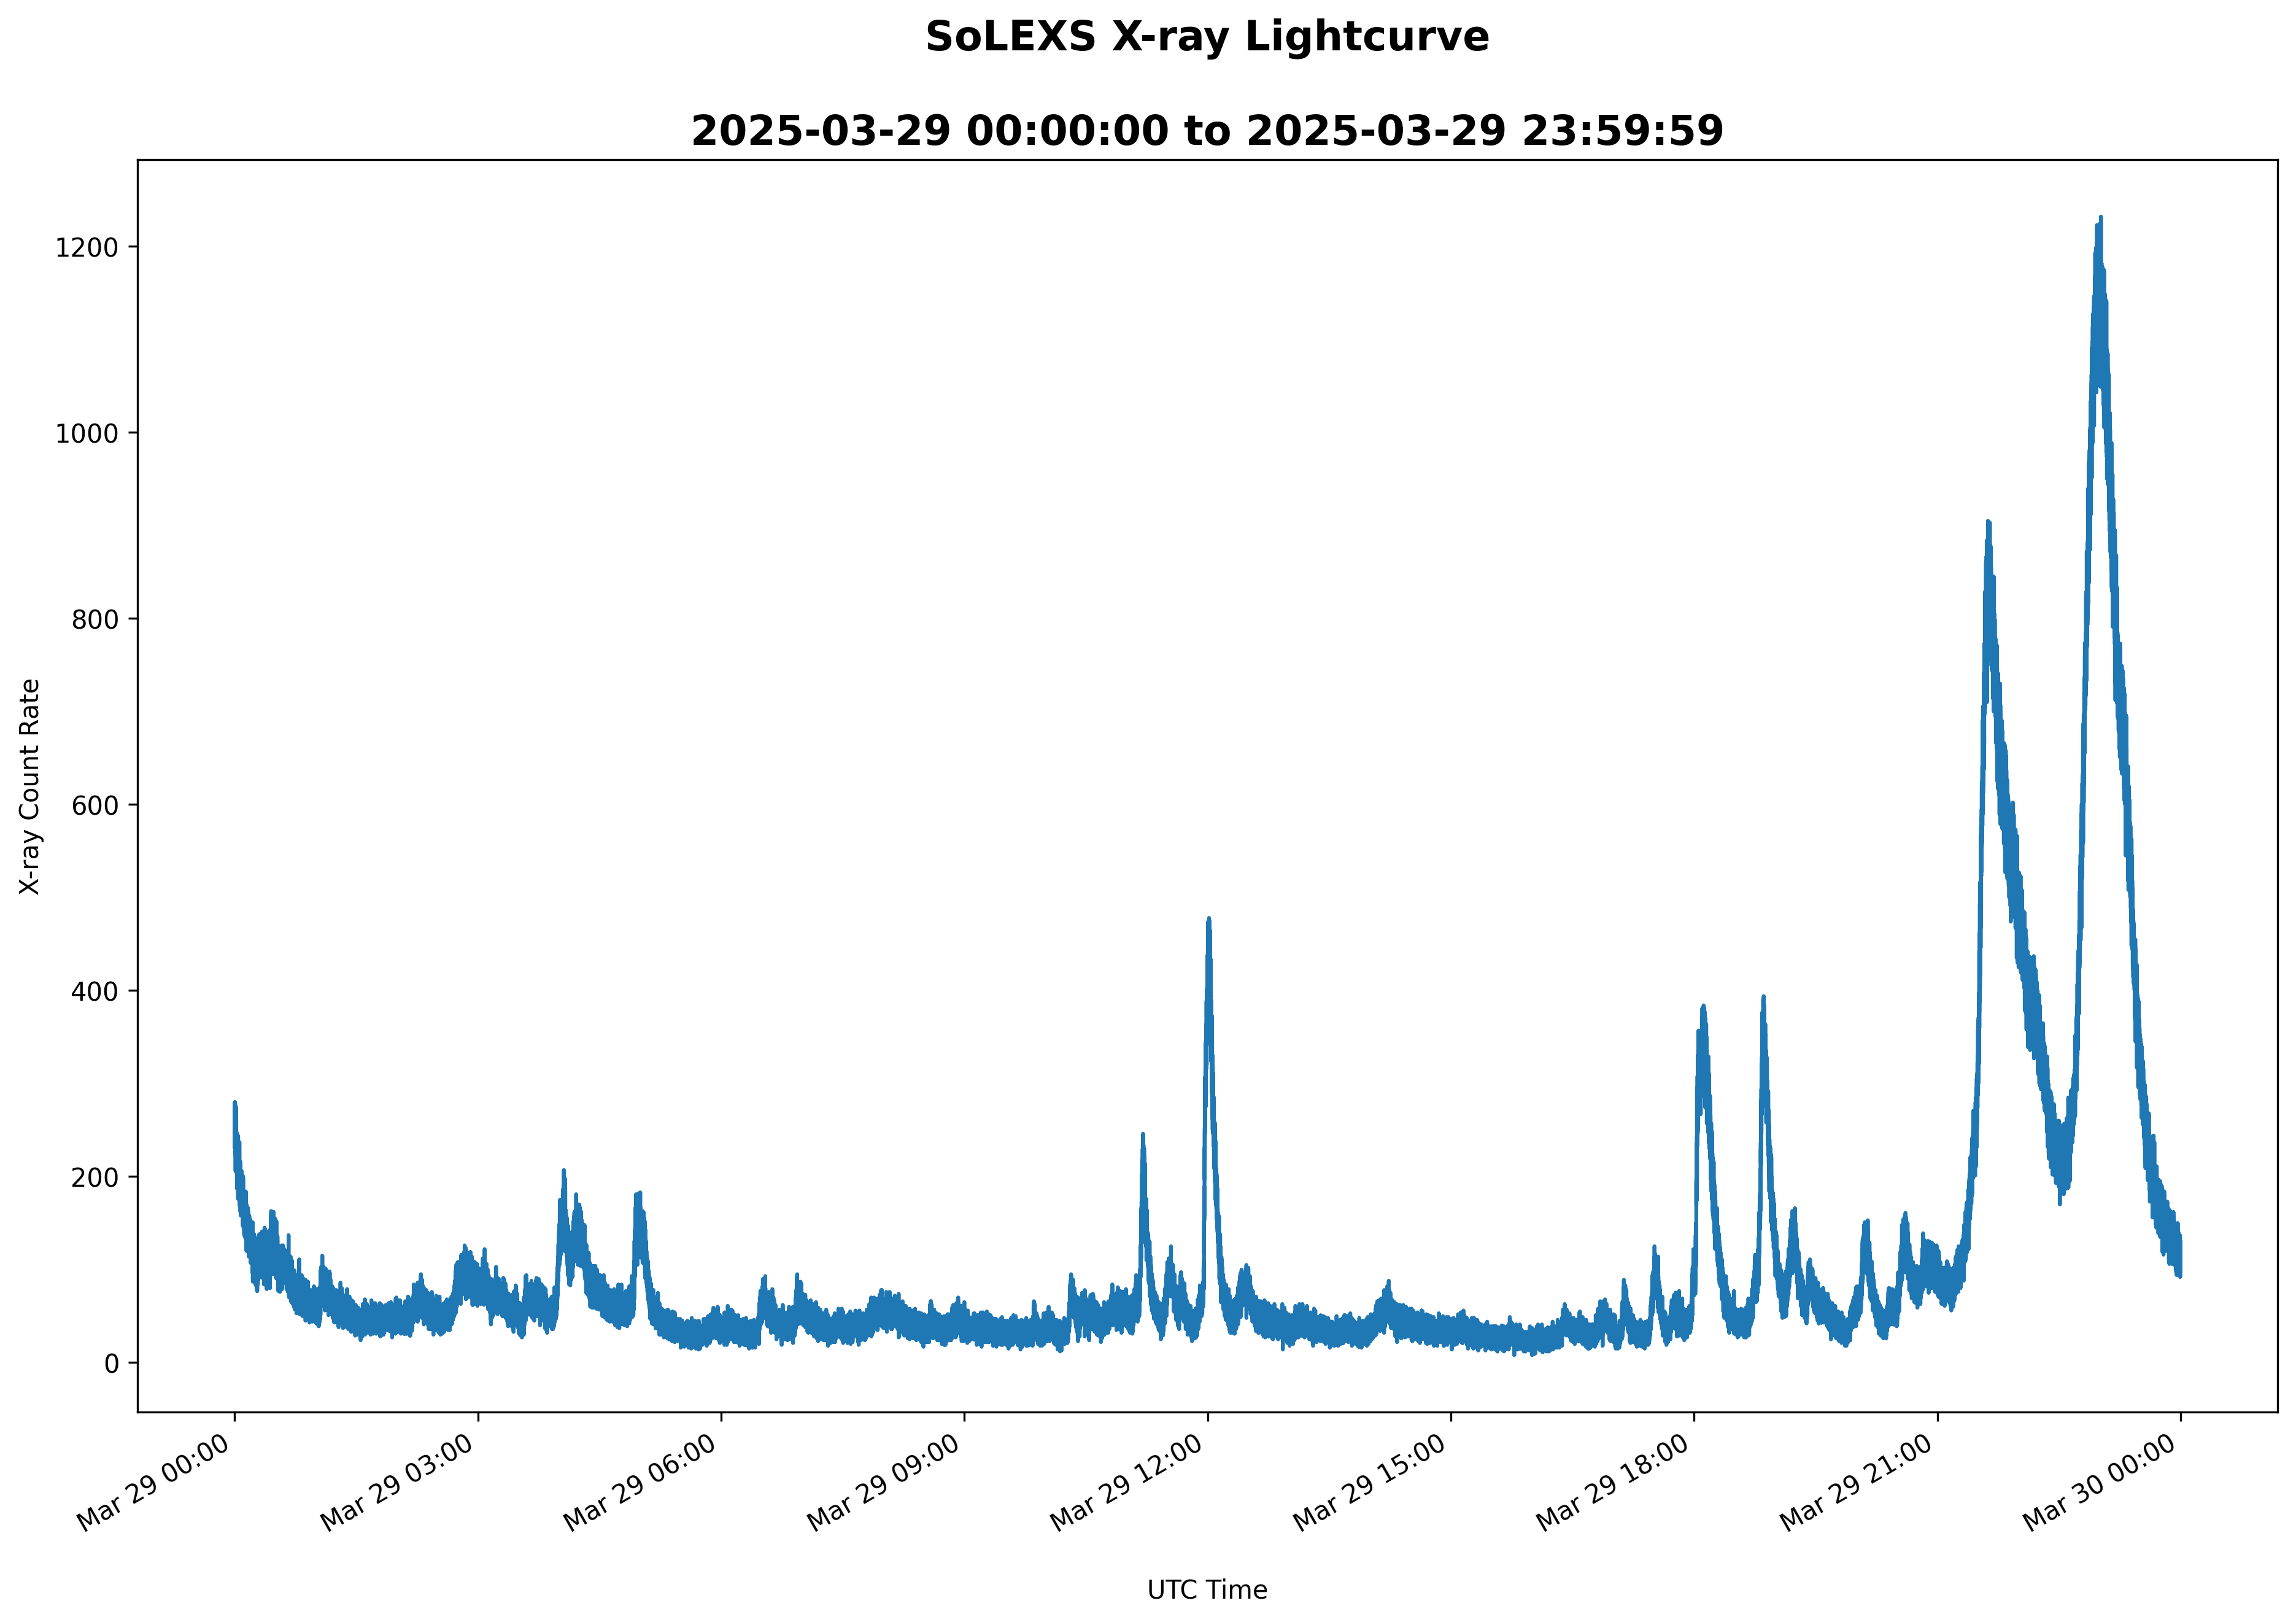

In [9]:
start_date = '2025-03-29'
end_date   = '2025-03-29'

df = SoLEXS_df[(SoLEXS_df['DATE'] >= start_date) & (SoLEXS_df['DATE'] <= end_date)].copy()

start_time = Time(df['TIME'].iloc[0], format='unix').to_datetime().strftime('%H:%M:%S')
end_time = Time(df['TIME'].iloc[-1], format='unix').to_datetime().strftime('%H:%M:%S')

plt_times = Time(df['TIME'], format='unix').to_datetime()
plt.figure(figsize=(15, 10), dpi=300)
plt.plot(plt_times, df['COUNTS'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.xlabel("\nUTC Time")
plt.ylabel("X-ray Count Rate")
plt.title(f"SoLEXS X-ray Lightcurve\n\n{start_date} {start_time} to {end_date} {end_time}", fontsize=16, fontweight='bold')
plt.show()

In [6]:
baseline = np.nanmedian(SoLEXS_df['COUNTS'])
std_dev = np.nanstd(SoLEXS_df['COUNTS'])
threshold = baseline + 5 * std_dev

times = df['TIME'].values
# flare_indices = np.where(df['COUNTS'] > threshold)[0]
flare_times = Time(np.unique(times), format='unix', scale='utc')
t_ref = Time(times[0], format='unix', scale='utc')
flare_offsets = (flare_times - t_ref).sec

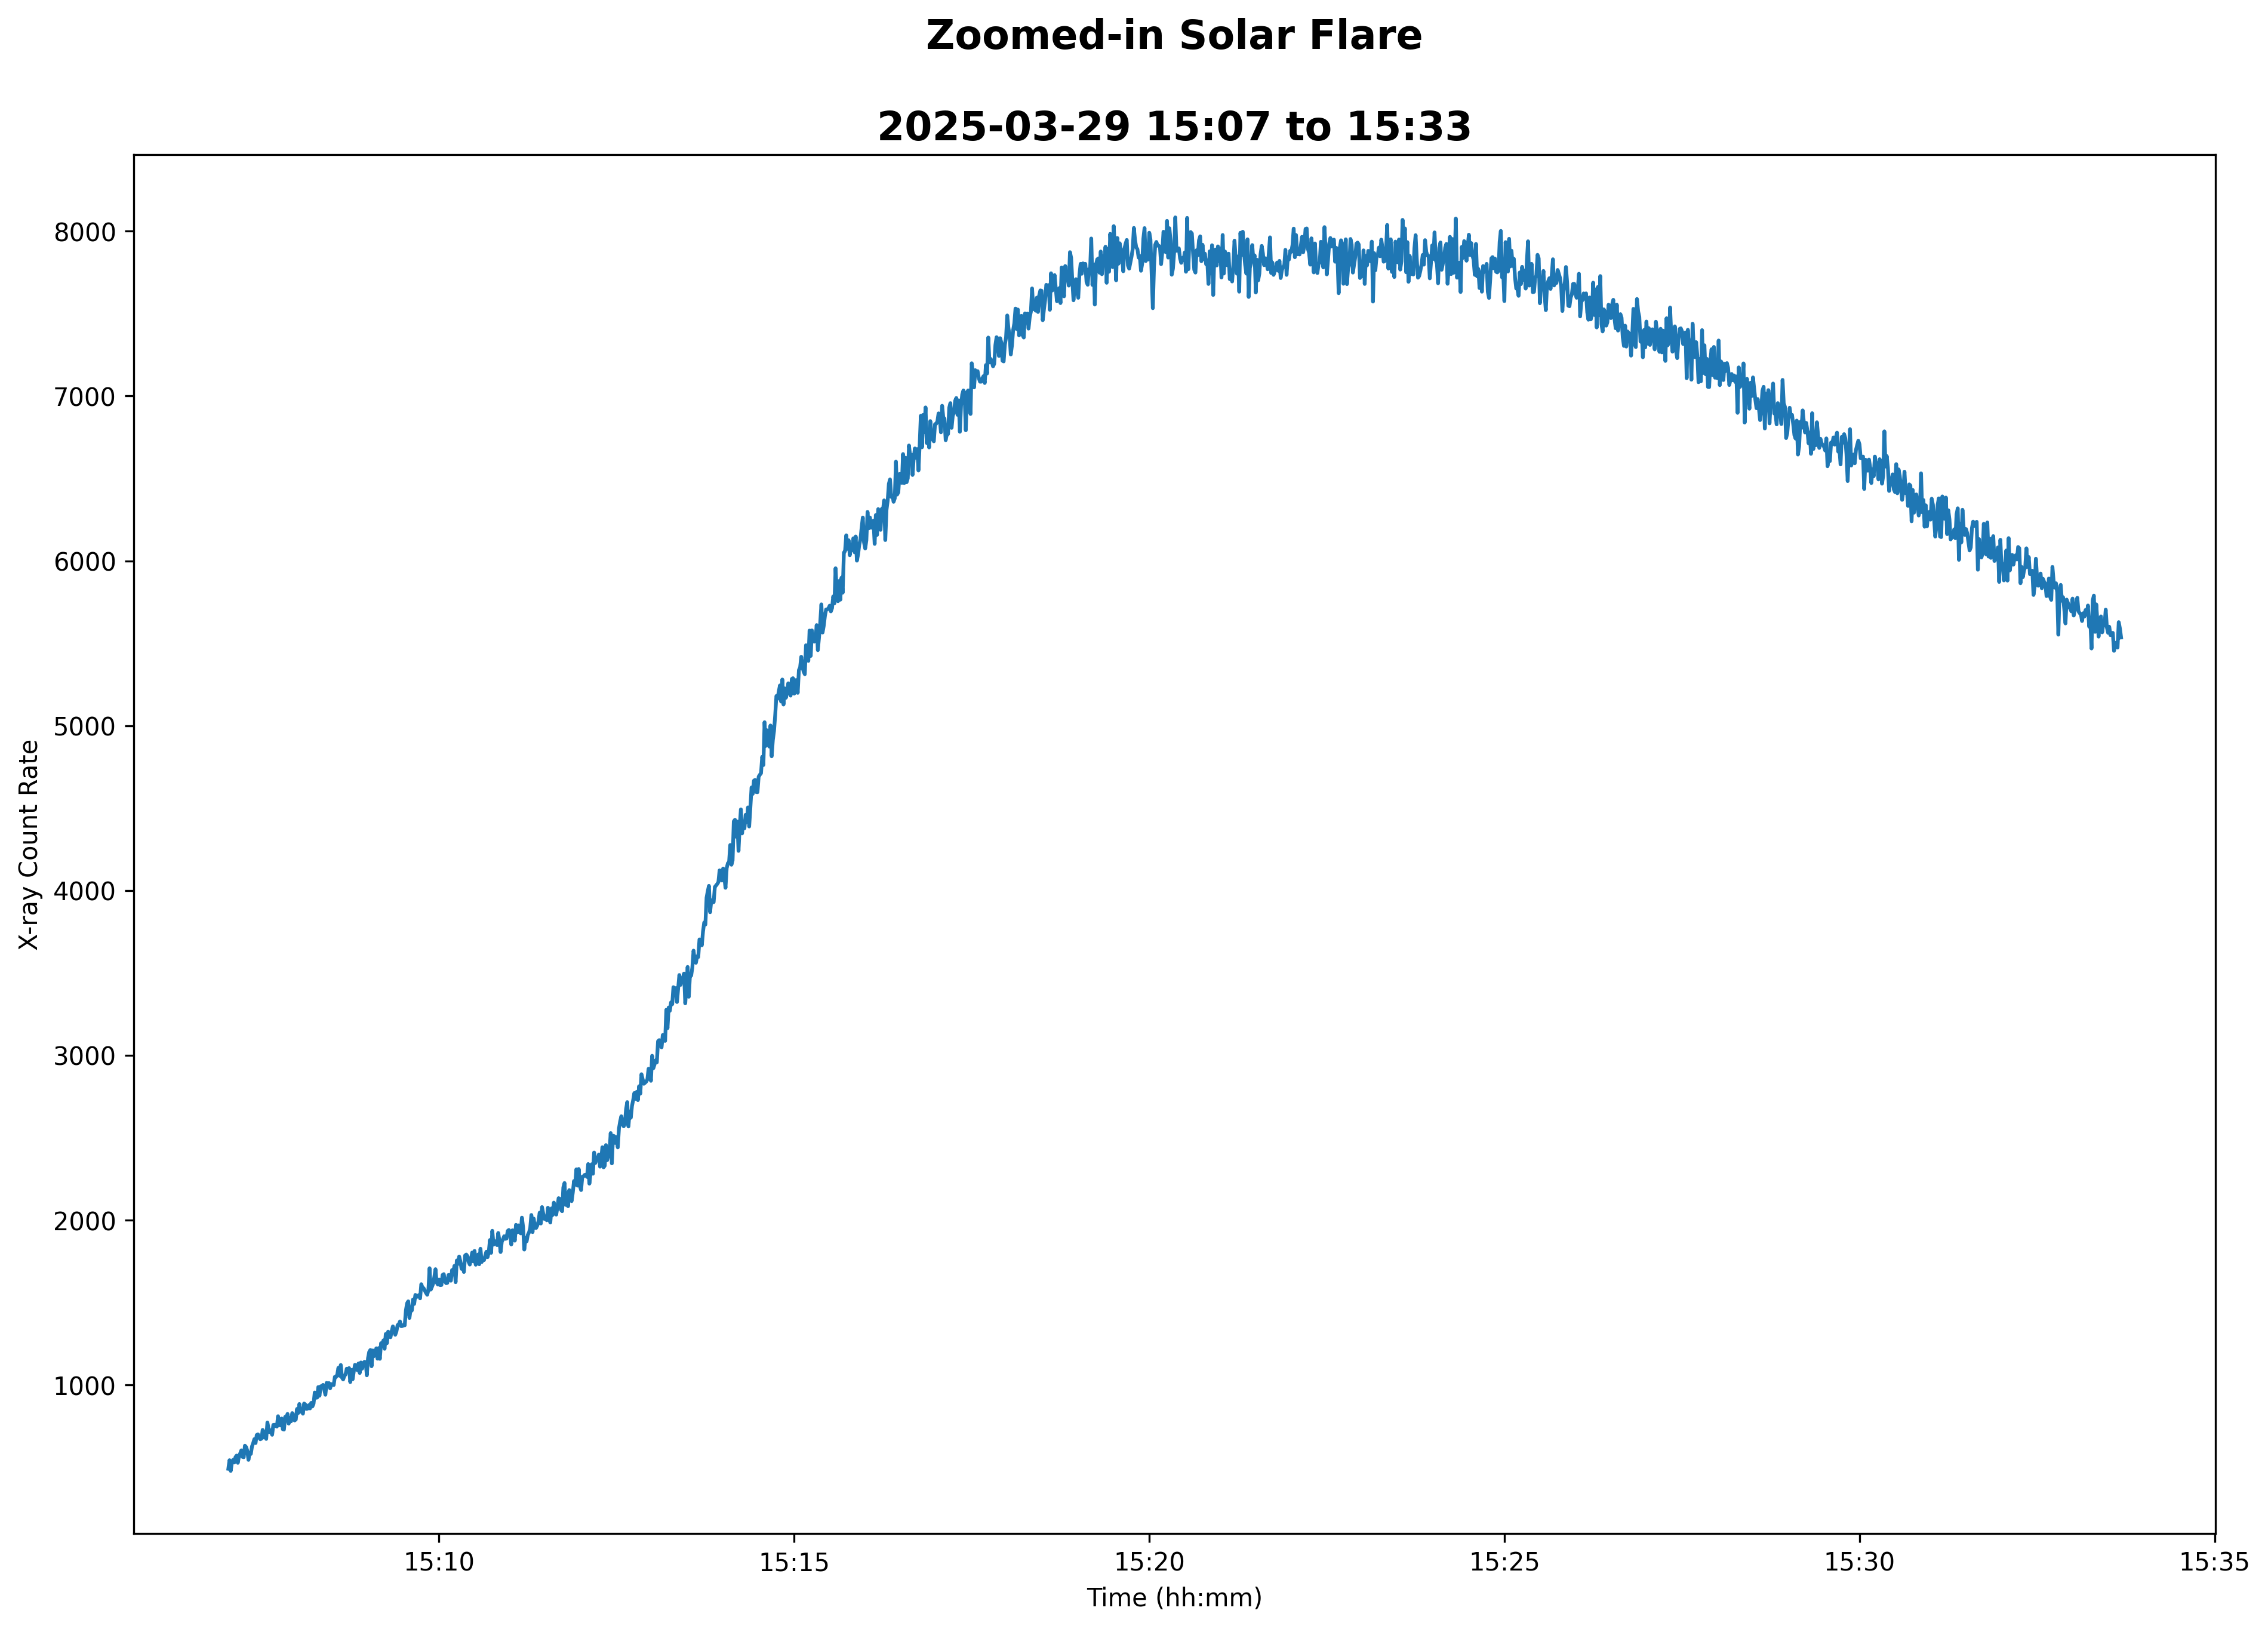

In [8]:
peak_idx = np.nanargmax(df['COUNTS'])
window = 800  # seconds around peak
start = peak_idx - window
end = peak_idx + window

time_subset = Time(df['TIME'][start:end], format='unix').to_datetime()

plt.figure(figsize=(15, 10), dpi=300)
plt.plot(time_subset, df['COUNTS'][start:end])
plt.xlabel("Time (hh:mm)")
plt.ylabel("X-ray Count Rate")
plt.title(f"Zoomed-in Solar Flare\n\n{df['DATE'].iloc[-1].strftime('%Y-%m-%d')} {time_subset[0].strftime('%H:%M')} to {time_subset[-1].strftime('%H:%M')}", fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()